# Phase 6: Project Duration Estimator (Interactive)

**Objective**: Interactive tool for tender estimation with real-time parameter adjustment.

**Real-World Application:**
```
TOTAL PROJECT = Mob + Transit-In + [Calibration + Operation] + Transit-Out + Demob
                                    └────────────────────────┘
                                    Weather delay applies HERE
```

**Forecasting Methodology:**
- Uses **historical climatology** (2015-2025) to predict future conditions
- Industry-standard approach for offshore tender estimation
- Assumes future weather patterns follow historical statistical distribution
- For dates beyond 2025: Uses same-month/same-day historical patterns
- Provides P50/P80/P90 confidence levels based on historical variability

**Features:**
- 🎯 **Interactive widgets** - Adjust all parameters in real-time
- 📅 **Date picker** - Select any start date (uses historical climatology)
- ⚙️ **Operation type** - Switch between Crane/Diving/ROV
- 📊 **Live updates** - Results update automatically
- 📈 **Visualizations** - Gantt chart, breakdowns, comparisons

**How to Use:**
1. Run all cells sequentially
2. Scroll to the interactive widget (Part 2)
3. Adjust sliders and dropdowns
4. See results update in real-time!

---"

## PART 1: SETUP & CONFIGURATION

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 10)

print("✅ Imports complete")

✅ Imports complete


In [2]:
# Cell 2: Load Historical Data

print("="*80)
print("LOADING HISTORICAL DATA")
print("="*80)

# Load hourly data
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

print(f"\n✓ Loaded {len(df):,} hourly records (2015-2025)")
print(f"  Variables: Hs, Wind, Current")
print("="*80)

LOADING HISTORICAL DATA

✓ Loaded 15,859 hourly records (2015-2025)
  Variables: Hs, Wind, Current


## PART 2: PROJECT CONFIGURATION

In [ ]:
# Cell 3: Interactive Project Configuration

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.patches as mpatches

print("="*80)
print("INTERACTIVE PROJECT ESTIMATOR")
print("="*80)
print("\n📋 Adjust parameters below and see results update in real-time!")
print("📊 Uses historical climatology (2015-2025) for weather prediction\n")

# Define operation limits
OPERATION_LIMITS = {
    'Crane': {'hs': 2.0, 'wind': 15.0},
    'Diving': {'hs': 2.0, 'current': 0.8},
    'ROV': {'hs': 2.5, 'wind': 18.0}
}

# Create interactive widgets
start_date_widget = widgets.DatePicker(
    description='Start Date:',
    value=pd.to_datetime('2026-06-15'),
    style={'description_width': '150px'}
)

operation_type_widget = widgets.Dropdown(
    options=['Crane', 'Diving', 'ROV'],
    value='Crane',
    description='Operation Type:',
    style={'description_width': '150px'}
)

calibration_widget = widgets.FloatSlider(
    value=3.0,
    min=0.5,
    max=10.0,
    step=0.5,
    description='Calibration Days:',
    style={'description_width': '150px'},
    readout_format='.1f'
)

operation_widget = widgets.FloatSlider(
    value=30.0,
    min=1.0,
    max=90.0,
    step=0.5,
    description='Operation Days:',
    style={'description_width': '150px'},
    readout_format='.1f'
)

mob_widget = widgets.FloatSlider(
    value=3.0,
    min=0.5,
    max=10.0,
    step=0.5,
    description='Mobilisation Days:',
    style={'description_width': '150px'},
    readout_format='.1f'
)

transit_in_widget = widgets.FloatSlider(
    value=2.0,
    min=0.5,
    max=10.0,
    step=0.5,
    description='Transit In Days:',
    style={'description_width': '150px'},
    readout_format='.1f'
)

transit_out_widget = widgets.FloatSlider(
    value=2.0,
    min=0.5,
    max=10.0,
    step=0.5,
    description='Transit Out Days:',
    style={'description_width': '150px'},
    readout_format='.1f'
)

demob_widget = widgets.FloatSlider(
    value=3.0,
    min=0.5,
    max=10.0,
    step=0.5,
    description='Demobilisation Days:',
    style={'description_width': '150px'},
    readout_format='.1f'
)

confidence_widget = widgets.Dropdown(
    options=['P50', 'P80', 'P90'],
    value='P90',
    description='Confidence Level:',
    style={'description_width': '150px'}
)

contingency_widget = widgets.Checkbox(
    value=True,
    description='Include 10% Contingency',
    style={'description_width': '150px'}
)

# Output area
output = widgets.Output()

# Main calculation function
def calculate_and_display(change=None):
    with output:
        clear_output(wait=True)
        
        # Get current values
        start_date = pd.to_datetime(start_date_widget.value)
        op_type = operation_type_widget.value
        calibration_days = calibration_widget.value
        operation_days = operation_widget.value
        mob_days = mob_widget.value
        transit_in_days = transit_in_widget.value
        transit_out_days = transit_out_widget.value
        demob_days = demob_widget.value
        confidence = confidence_widget.value
        include_contingency = contingency_widget.value
        
        # Calculate derived values
        weather_dependent_days = calibration_days + operation_days
        fixed_days = mob_days + transit_in_days + transit_out_days + demob_days
        start_month = start_date.strftime('%B')
        target_month = start_date.month
        target_day = start_date.day
        
        # Get operation limits
        limits = OPERATION_LIMITS[op_type]
        
        # Mark workable hours
        df_calc = df.copy()
        if op_type == 'Crane':
            df_calc['workable'] = (df_calc['hs'] <= limits['hs']) & (df_calc['wind_speed'] <= limits['wind'])
        elif op_type == 'Diving':
            # Check if current column exists
            if 'current_mean' in df_calc.columns:
                df_calc['workable'] = (df_calc['hs'] <= limits['hs']) & (df_calc['current_mean'] <= limits['current'])
            elif 'current' in df_calc.columns:
                df_calc['workable'] = (df_calc['hs'] <= limits['hs']) & (df_calc['current'] <= limits['current'])
            else:
                # Fallback: just use Hs if current not available
                df_calc['workable'] = (df_calc['hs'] <= limits['hs'])
        elif op_type == 'ROV':
            df_calc['workable'] = (df_calc['hs'] <= limits['hs']) & (df_calc['wind_speed'] <= limits['wind'])
        
        df_calc['month'] = df_calc.index.month
        df_calc['day'] = df_calc.index.day
        df_calc['year'] = df_calc.index.year
        
        # Historical analysis
        window_days = int(weather_dependent_days + 30)
        historical_periods = []
        
        for year in df_calc['year'].unique():
            try:
                period_start = pd.Timestamp(year=year, month=target_month, day=target_day)
                period_end = period_start + timedelta(days=window_days)
                period_data = df_calc[period_start:period_end]
                
                if len(period_data) > 0:
                    workable_pct = period_data['workable'].mean()
                    historical_periods.append({
                        'year': year,
                        'workable_pct': workable_pct
                    })
            except:
                pass
        
        df_historical = pd.DataFrame(historical_periods)
        mean_workability = df_historical['workable_pct'].mean()
        
        # Calculate duration with different confidence levels
        def calc_duration(req_days, work_pct, conf='P50'):
            if work_pct <= 0:
                return np.inf
            p50 = req_days / work_pct
            
            if conf == 'P50':
                return p50
            elif conf == 'P80':
                return p50 * 1.10  # 10% buffer for P80
            elif conf == 'P90':
                return p50 * 1.20  # 20% buffer for P90
            else:
                return p50
        
        weather_calendar_days = calc_duration(weather_dependent_days, mean_workability, confidence)
        weather_delay = weather_calendar_days - weather_dependent_days
        total_duration = fixed_days + weather_calendar_days
        end_date = start_date + timedelta(days=int(total_duration))
        
        if include_contingency:
            contingency_days = total_duration * 0.10
            total_with_contingency = total_duration + contingency_days
            end_with_contingency = start_date + timedelta(days=int(total_with_contingency))
        
        # DISPLAY RESULTS
        sep = "=" * 80
        dash = "-" * 80
        
        print(sep)
        print(f"PROJECT ESTIMATE: {start_month} {target_day}, {start_date.year}")
        print(f"Based on historical climatology ({len(df_historical)} years of data)")
        print(sep)
        
        print(f"\n📋 CONFIGURATION:")
        print(f"  Operation: {op_type}")
        print(f"  Weather-Dependent: {weather_dependent_days:.1f} days (Calib: {calibration_days:.1f}, Op: {operation_days:.1f})")
        print(f"  Fixed Duration: {fixed_days:.1f} days (Mob: {mob_days:.1f}, Transit: {transit_in_days:.1f}+{transit_out_days:.1f}, Demob: {demob_days:.1f})")
        print(f"  Confidence: {confidence}")
        
        print(f"\n📊 RESULTS:")
        print(dash)
        print(f"  Total Duration: {total_duration:.1f} calendar days ({confidence})")
        print(f"  Weather Delay: {weather_delay:.1f} days")
        print(f"  Workability: {mean_workability*100:.1f}%")
        print(f"  End Date: {end_date.strftime('%d-%B-%Y')}")
        
        if include_contingency:
            print(f"\n  With 10% Contingency: {total_with_contingency:.1f} days")
            print(f"  End Date (Contingency): {end_with_contingency.strftime('%d-%B-%Y')}")
        
        print(f"\n📅 TIMELINE BREAKDOWN:")
        print(dash)
        current = start_date
        print(f"  Start: {current.strftime('%d-%b-%Y')}")
        
        current += timedelta(days=mob_days)
        print(f"  After Mob ({mob_days:.1f}d): {current.strftime('%d-%b-%Y')}")
        
        current += timedelta(days=transit_in_days)
        print(f"  Arrive Site ({transit_in_days:.1f}d): {current.strftime('%d-%b-%Y')}")
        
        current += timedelta(days=weather_calendar_days)
        print(f"  Complete Work ({weather_calendar_days:.1f}d): {current.strftime('%d-%b-%Y')} ⚠️ Weather-Dependent")
        
        current += timedelta(days=transit_out_days)
        print(f"  Leave Site ({transit_out_days:.1f}d): {current.strftime('%d-%b-%Y')}")
        
        current += timedelta(days=demob_days)
        print(f"  Demobilised ({demob_days:.1f}d): {current.strftime('%d-%b-%Y')}")
        
        # Gantt Chart
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        
        # Plot 1: Gantt
        ax1 = axes[0]
        phases = [
            ('Mob', mob_days, 'lightblue'),
            ('Transit In', transit_in_days, 'lightgreen'),
            ('Calib', calibration_days * (weather_calendar_days/weather_dependent_days), 'orange'),
            ('Operation', operation_days * (weather_calendar_days/weather_dependent_days), 'red'),
            ('Transit Out', transit_out_days, 'lightgreen'),
            ('Demob', demob_days, 'lightblue')
        ]
        
        cumulative = 0
        for phase, duration, color in phases:
            ax1.barh(0, duration, left=cumulative, color=color, edgecolor='black', height=0.5)
            ax1.text(cumulative + duration/2, 0, f'{phase}\n{duration:.1f}d', 
                     ha='center', va='center', fontsize=10, fontweight='bold')
            cumulative += duration
        
        ax1.set_xlim(0, cumulative)
        ax1.set_ylim(-0.5, 0.5)
        ax1.set_xlabel('Days', fontweight='bold', fontsize=12)
        ax1.set_title(f'Project Timeline ({confidence})', fontweight='bold', fontsize=14)
        ax1.set_yticks([])
        ax1.grid(True, axis='x', alpha=0.3)
        
        # Plot 2: Breakdown
        ax2 = axes[1]
        breakdown_vals = [fixed_days, weather_dependent_days, weather_delay]
        breakdown_labels = ['Fixed\nDays', 'Working\nDays', 'Weather\nDelay']
        colors_pie = ['lightblue', 'orange', 'red']
        ax2.pie(breakdown_vals, labels=breakdown_labels, autopct='%1.1f%%', 
                colors=colors_pie, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
        ax2.set_title(f'Duration Breakdown\nTotal: {total_duration:.1f} days', 
                      fontweight='bold', fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Results updated!")
        print(sep)

# Attach observers to all widgets
start_date_widget.observe(calculate_and_display, names='value')
operation_type_widget.observe(calculate_and_display, names='value')
calibration_widget.observe(calculate_and_display, names='value')
operation_widget.observe(calculate_and_display, names='value')
mob_widget.observe(calculate_and_display, names='value')
transit_in_widget.observe(calculate_and_display, names='value')
transit_out_widget.observe(calculate_and_display, names='value')
demob_widget.observe(calculate_and_display, names='value')
confidence_widget.observe(calculate_and_display, names='value')
contingency_widget.observe(calculate_and_display, names='value')

# Create layout
left_col = widgets.VBox([
    widgets.HTML('<h3>📅 Date & Operation</h3>'),
    start_date_widget,
    operation_type_widget,
    widgets.HTML('<h3>⚙️ Weather-Dependent Days</h3>'),
    calibration_widget,
    operation_widget,
])

right_col = widgets.VBox([
    widgets.HTML('<h3>🚢 Fixed Duration Days</h3>'),
    mob_widget,
    transit_in_widget,
    transit_out_widget,
    demob_widget,
    widgets.HTML('<h3>📊 Analysis Options</h3>'),
    confidence_widget,
    contingency_widget,
])

controls = widgets.HBox([left_col, right_col])

# Display
display(controls)
display(output)

# Initial calculation
calculate_and_display()

## PART 3: OPTIONAL - Month-by-Month Comparison

**Note**: This section provides additional analysis comparing all 12 months. Run this if you want to see which months are best for scheduling."

In [4]:
# Cell 4: Extract Historical Data for Target Month

print("\n[PART 3] Historical Weather Analysis...\n")

# Extract month and day
target_month = start_date.month
target_day = start_date.day

# Get operation limits
op_type = PROJECT_CONFIG['operation_type']
limits = OPERATION_LIMITS[op_type]

# Mark workable hours
if op_type == 'Crane':
    df['workable'] = (df['hs'] <= limits['hs']) & (df['wind_speed'] <= limits['wind'])
elif op_type == 'Diving':
    df['workable'] = (df['hs'] <= limits['hs']) & (df['current_mean'] <= limits['current'])
elif op_type == 'ROV':
    df['workable'] = (df['hs'] <= limits['hs']) & (df['wind_speed'] <= limits['wind'])

# Filter for target month across all years
df['month'] = df.index.month
df['day'] = df.index.day
df['year'] = df.index.year

# Get similar timeframes from historical data
window_days = weather_dependent_days + 30  # Add buffer for weather delay

historical_periods = []

for year in df['year'].unique():
    try:
        period_start = pd.Timestamp(year=year, month=target_month, day=target_day)
        period_end = period_start + timedelta(days=window_days)
        
        period_data = df[period_start:period_end]
        
        if len(period_data) > 0:
            workable_pct = period_data['workable'].mean()
            historical_periods.append({
                'year': year,
                'start': period_start,
                'end': period_end,
                'workable_pct': workable_pct,
                'n_hours': len(period_data),
                'workable_hours': period_data['workable'].sum()
            })
    except:
        pass  # Skip invalid dates

df_historical = pd.DataFrame(historical_periods)

print("="*80)
print(f"HISTORICAL ANALYSIS: {start_month} {target_day} (± {window_days} days)")
print("="*80)
print(df_historical[['year', 'workable_pct', 'workable_hours']].to_string(index=False))

mean_workability = df_historical['workable_pct'].mean()
std_workability = df_historical['workable_pct'].std()

print("\n" + "-"*80)
print(f"Mean Workability: {mean_workability*100:.1f}% (±{std_workability*100:.1f}%)")
print("-"*80)

print("\n✓ Historical analysis complete")


[PART 3] Historical Weather Analysis...

HISTORICAL ANALYSIS: June 15 (± 63 days)
 year  workable_pct  workable_hours
 2015      0.944664             239
 2016      0.956522             242
 2017      0.956522             242
 2018      0.972332             246
 2019      0.996047             252
 2020      0.988142             250
 2021      0.980237             248
 2022      0.984190             249
 2023      0.992095             251
 2024      0.976285             247
 2025      0.968379             245

--------------------------------------------------------------------------------
Mean Workability: 97.4% (±1.6%)
--------------------------------------------------------------------------------

✓ Historical analysis complete


## PART 4: WEATHER DELAY CALCULATION

In [5]:
# Cell 5: Calculate Weather Delay Using Historical Patterns

print("\n[PART 4] Weather Delay Calculation...\n")

def calculate_project_duration(required_days, workable_pct, confidence='P50'):
    """
    Calculate total calendar days needed for N working days.
    
    Simple model:
    calendar_days = required_days / workable_pct
    
    For P90: Add safety margin based on variability
    """
    if workable_pct <= 0:
        return np.inf
    
    # Base estimate
    p50_days = required_days / workable_pct
    
    if confidence == 'P50':
        return p50_days
    elif confidence == 'P90':
        # P90: Add buffer based on uncertainty
        # Assume ~15-20% additional time for P90
        safety_factor = 1.20
        return p50_days * safety_factor
    else:
        return p50_days


# Calculate for each historical year
duration_estimates = []

for idx, row in df_historical.iterrows():
    p50 = calculate_project_duration(weather_dependent_days, row['workable_pct'], 'P50')
    p90 = calculate_project_duration(weather_dependent_days, row['workable_pct'], 'P90')
    
    duration_estimates.append({
        'year': row['year'],
        'workable_pct': row['workable_pct'],
        'calendar_days_p50': p50,
        'calendar_days_p90': p90,
        'weather_delay_p50': p50 - weather_dependent_days,
        'weather_delay_p90': p90 - weather_dependent_days
    })

df_duration = pd.DataFrame(duration_estimates)

print("="*80)
print("WEATHER DELAY ESTIMATES (Calendar Days for Weather-Dependent Work)")
print("="*80)
print(f"Required Working Days: {weather_dependent_days}")
print("-"*80)
print(df_duration.to_string(index=False, float_format=lambda x: f"{x:.1f}"))

# Summary statistics
mean_p50 = df_duration['calendar_days_p50'].mean()
mean_p90 = df_duration['calendar_days_p90'].mean()
mean_delay_p50 = df_duration['weather_delay_p50'].mean()
mean_delay_p90 = df_duration['weather_delay_p90'].mean()

print("\n" + "="*80)
print("SUMMARY (10-Year Average):")
print("="*80)
print(f"P50 Estimate:")
print(f"  Calendar days needed: {mean_p50:.1f} days")
print(f"  Weather delay: {mean_delay_p50:.1f} days")
print(f"\nP90 Estimate (Conservative):")
print(f"  Calendar days needed: {mean_p90:.1f} days")
print(f"  Weather delay: {mean_delay_p90:.1f} days")
print("="*80)

print("\n✓ Weather delay calculated")


[PART 4] Weather Delay Calculation...

WEATHER DELAY ESTIMATES (Calendar Days for Weather-Dependent Work)
Required Working Days: 33
--------------------------------------------------------------------------------
 year  workable_pct  calendar_days_p50  calendar_days_p90  weather_delay_p50  weather_delay_p90
 2015           0.9               34.9               41.9                1.9                8.9
 2016           1.0               34.5               41.4                1.5                8.4
 2017           1.0               34.5               41.4                1.5                8.4
 2018           1.0               33.9               40.7                0.9                7.7
 2019           1.0               33.1               39.8                0.1                6.8
 2020           1.0               33.4               40.1                0.4                7.1
 2021           1.0               33.7               40.4                0.7                7.4
 2022           1.

## PART 5: TOTAL PROJECT DURATION

In [6]:
# Cell 6: Calculate Total Project Duration

print("\n[PART 5] Total Project Duration...\n")

# Select confidence level from config
confidence = PROJECT_CONFIG['confidence_level']

if confidence == 'P50':
    weather_calendar_days = mean_p50
    weather_delay = mean_delay_p50
else:  # P90
    weather_calendar_days = mean_p90
    weather_delay = mean_delay_p90

# Total project duration
total_duration = fixed_days + weather_calendar_days

# Calculate end date
end_date = start_date + timedelta(days=int(total_duration))

print("="*80)
print(f"TOTAL PROJECT DURATION ({confidence})")
print("="*80)

print("\n📅 TIMELINE BREAKDOWN:")
print("-"*80)

current_date = start_date

print(f"Start Date: {current_date.strftime('%d-%B-%Y')}")
print(f"\n1. Mobilisation: {PROJECT_CONFIG['mobilisation_days']} days")
current_date += timedelta(days=PROJECT_CONFIG['mobilisation_days'])

print(f"2. Transit to Site: {PROJECT_CONFIG['transit_to_site_days']} days")
current_date += timedelta(days=PROJECT_CONFIG['transit_to_site_days'])

print(f"\n3. ON-SITE WORK (Weather-Dependent): {weather_calendar_days:.1f} calendar days")
print(f"   - Calibration: {PROJECT_CONFIG['calibration_days']} working days")
print(f"   - Operation: {PROJECT_CONFIG['operation_days']} working days")
print(f"   - Weather Delay: {weather_delay:.1f} days ⚠️")
current_date += timedelta(days=int(weather_calendar_days))

print(f"\n4. Transit from Site: {PROJECT_CONFIG['transit_from_site_days']} days")
current_date += timedelta(days=PROJECT_CONFIG['transit_from_site_days'])

print(f"5. Demobilisation: {PROJECT_CONFIG['demobilisation_days']} days")
current_date += timedelta(days=PROJECT_CONFIG['demobilisation_days'])

print("\n" + "="*80)
print("📊 FINAL ESTIMATE:")
print("="*80)
print(f"Total Duration: {total_duration:.1f} calendar days")
print(f"End Date: {end_date.strftime('%d-%B-%Y')}")
print(f"\nBreakdown:")
print(f"  Fixed days: {fixed_days} days ({fixed_days/total_duration*100:.1f}%)")
print(f"  Working days: {weather_dependent_days} days")
print(f"  Weather delay: {weather_delay:.1f} days ({weather_delay/total_duration*100:.1f}%)")
print(f"  Efficiency: {weather_dependent_days/weather_calendar_days*100:.1f}%")
print("="*80)

if PROJECT_CONFIG['include_contingency']:
    contingency_days = total_duration * 0.10  # 10% contingency
    total_with_contingency = total_duration + contingency_days
    end_with_contingency = start_date + timedelta(days=int(total_with_contingency))
    
    print("\n⚠️  WITH CONTINGENCY (10%):")
    print("-"*80)
    print(f"Total Duration: {total_with_contingency:.1f} calendar days")
    print(f"End Date: {end_with_contingency.strftime('%d-%B-%Y')}")
    print(f"Additional Buffer: {contingency_days:.1f} days")
    print("="*80)


[PART 5] Total Project Duration...

TOTAL PROJECT DURATION (P90)

📅 TIMELINE BREAKDOWN:
--------------------------------------------------------------------------------
Start Date: 15-June-2026

1. Mobilisation: 3 days
2. Transit to Site: 2 days

3. ON-SITE WORK (Weather-Dependent): 40.7 calendar days
   - Calibration: 3 working days
   - Operation: 30 working days
   - Weather Delay: 7.7 days ⚠️

4. Transit from Site: 2 days
5. Demobilisation: 3 days

📊 FINAL ESTIMATE:
Total Duration: 50.7 calendar days
End Date: 04-August-2026

Breakdown:
  Fixed days: 10 days (19.7%)
  Working days: 33 days
  Weather delay: 7.7 days (15.1%)
  Efficiency: 81.2%

⚠️  WITH CONTINGENCY (10%):
--------------------------------------------------------------------------------
Total Duration: 55.7 calendar days
End Date: 09-August-2026
Additional Buffer: 5.1 days


## PART 6: VISUALIZATIONS

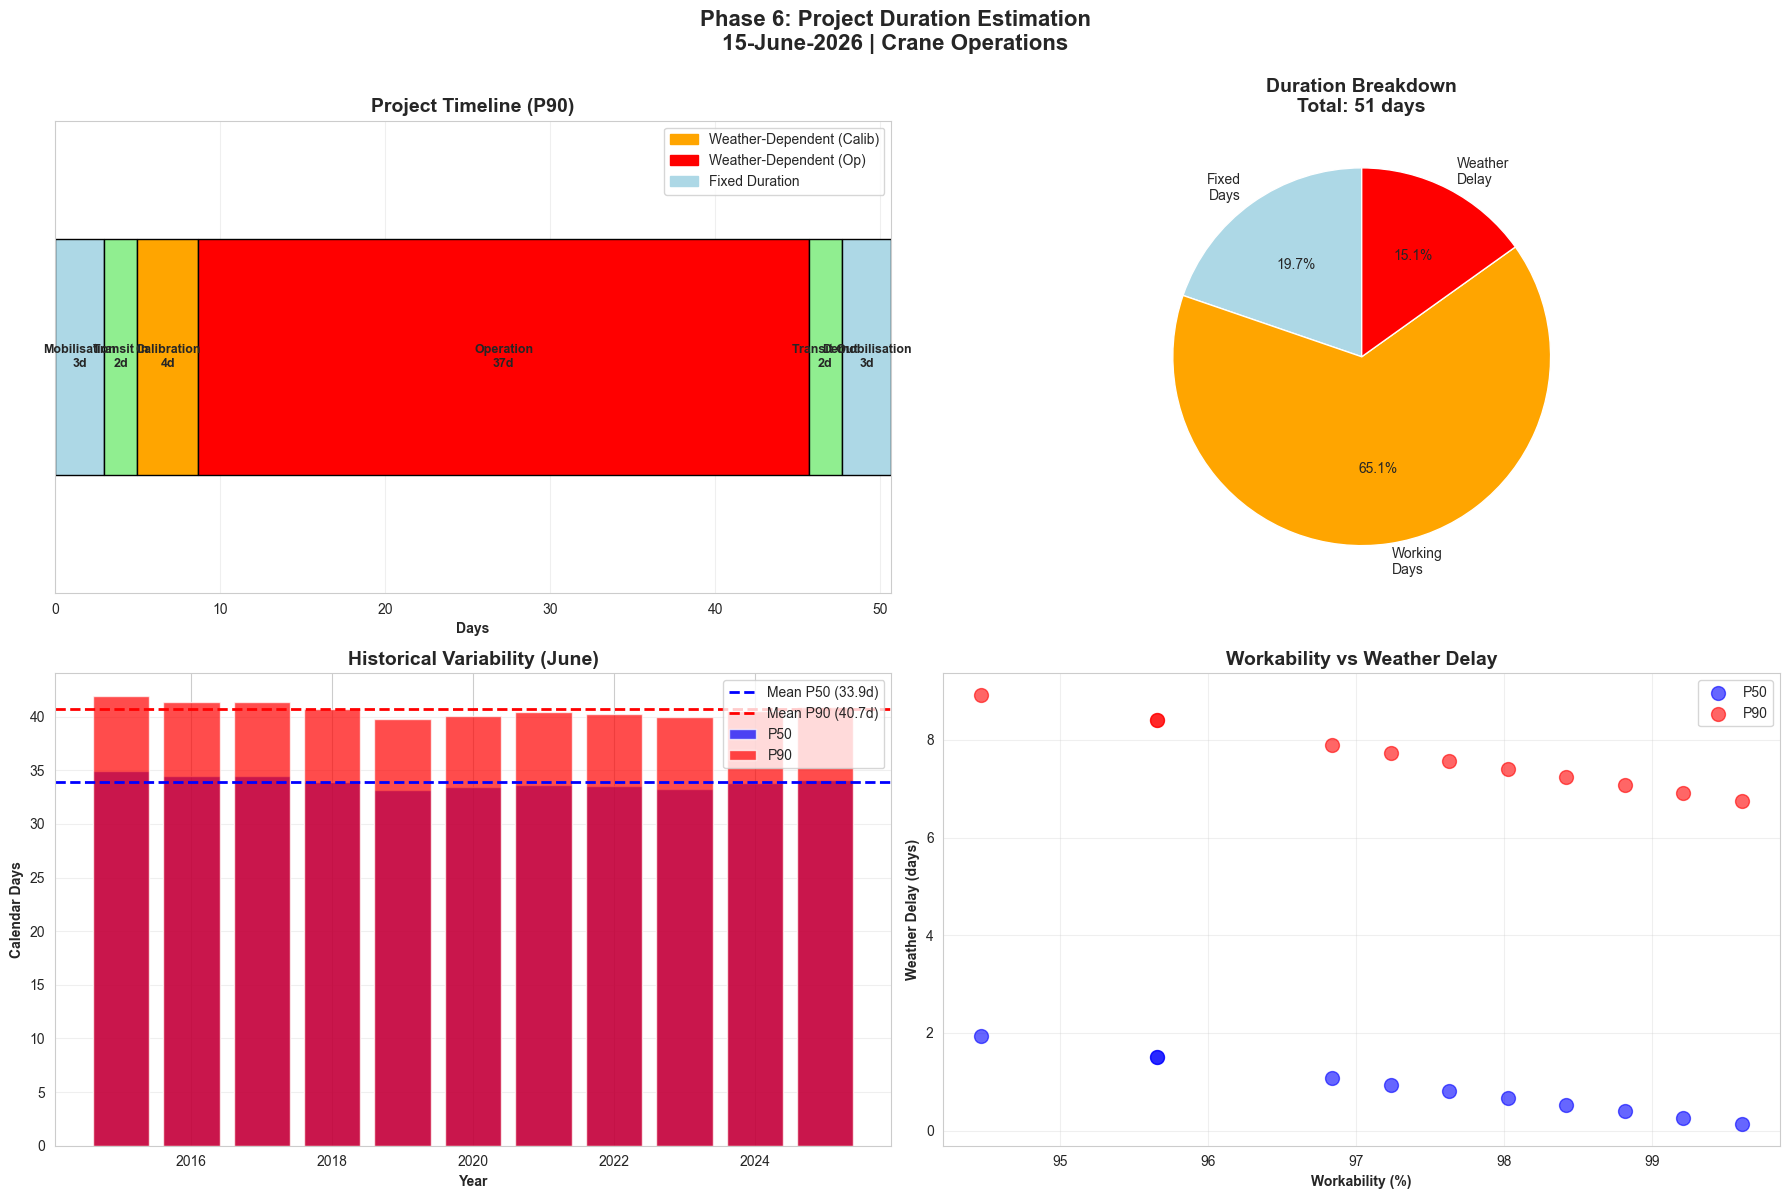


✓ Visualizations complete


In [7]:
# Cell 7: Project Timeline Visualization

import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Gantt Chart
ax1 = axes[0, 0]

phases = [
    ('Mobilisation', PROJECT_CONFIG['mobilisation_days'], 'lightblue'),
    ('Transit In', PROJECT_CONFIG['transit_to_site_days'], 'lightgreen'),
    ('Calibration', PROJECT_CONFIG['calibration_days'] * (weather_calendar_days/weather_dependent_days), 'orange'),
    ('Operation', PROJECT_CONFIG['operation_days'] * (weather_calendar_days/weather_dependent_days), 'red'),
    ('Transit Out', PROJECT_CONFIG['transit_from_site_days'], 'lightgreen'),
    ('Demobilisation', PROJECT_CONFIG['demobilisation_days'], 'lightblue')
]

cumulative = 0
for phase, duration, color in phases:
    ax1.barh(0, duration, left=cumulative, color=color, edgecolor='black', height=0.5)
    ax1.text(cumulative + duration/2, 0, f'{phase}\n{duration:.0f}d', 
             ha='center', va='center', fontsize=9, fontweight='bold')
    cumulative += duration

ax1.set_xlim(0, cumulative)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Days', fontweight='bold')
ax1.set_title(f'Project Timeline ({confidence})', fontweight='bold', fontsize=14)
ax1.set_yticks([])
ax1.grid(True, axis='x', alpha=0.3)

# Add legend
weather_patch = mpatches.Patch(color='orange', label='Weather-Dependent (Calib)')
operation_patch = mpatches.Patch(color='red', label='Weather-Dependent (Op)')
fixed_patch = mpatches.Patch(color='lightblue', label='Fixed Duration')
ax1.legend(handles=[weather_patch, operation_patch, fixed_patch], loc='upper right')

# Plot 2: Duration Breakdown
ax2 = axes[0, 1]
breakdown = {
    'Fixed\nDays': fixed_days,
    'Working\nDays': weather_dependent_days,
    'Weather\nDelay': weather_delay
}

colors_pie = ['lightblue', 'orange', 'red']
ax2.pie(breakdown.values(), labels=breakdown.keys(), autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
ax2.set_title(f'Duration Breakdown\nTotal: {total_duration:.0f} days', 
              fontweight='bold', fontsize=14)

# Plot 3: Historical Variability
ax3 = axes[1, 0]
ax3.bar(df_duration['year'], df_duration['calendar_days_p50'], 
        label='P50', alpha=0.7, color='blue')
ax3.bar(df_duration['year'], df_duration['calendar_days_p90'], 
        label='P90', alpha=0.7, color='red')
ax3.axhline(mean_p50, color='blue', linestyle='--', linewidth=2, label=f'Mean P50 ({mean_p50:.1f}d)')
ax3.axhline(mean_p90, color='red', linestyle='--', linewidth=2, label=f'Mean P90 ({mean_p90:.1f}d)')
ax3.set_xlabel('Year', fontweight='bold')
ax3.set_ylabel('Calendar Days', fontweight='bold')
ax3.set_title(f'Historical Variability ({start_month})', fontweight='bold', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Weather Delay vs Workability
ax4 = axes[1, 1]
ax4.scatter(df_duration['workable_pct']*100, df_duration['weather_delay_p50'], 
           s=100, alpha=0.6, color='blue', label='P50')
ax4.scatter(df_duration['workable_pct']*100, df_duration['weather_delay_p90'], 
           s=100, alpha=0.6, color='red', label='P90')
ax4.set_xlabel('Workability (%)', fontweight='bold')
ax4.set_ylabel('Weather Delay (days)', fontweight='bold')
ax4.set_title('Workability vs Weather Delay', fontweight='bold', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Phase 6: Project Duration Estimation\n{PROJECT_CONFIG["start_date"]} | {op_type} Operations', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")

## PART 7: MONTH-BY-MONTH COMPARISON


[PART 7] Month-by-Month Comparison...

MONTH-BY-MONTH COMPARISON (Total Project Duration)
    Month  Workability  Total_P50  Total_P90  Weather_Delay_P90
  January        66.5%       59.6       69.6               26.6
 February        67.5%       58.9       68.6               25.6
    March        79.0%       51.8       60.2               17.2
    April        87.3%       47.8       55.3               12.3
      May        92.5%       45.7       52.8                9.8
     June        94.8%       44.8       51.8                8.8
     July        98.0%       43.7       50.4                7.4
   August        96.3%       44.3       51.1                8.1
September        90.3%       46.5       53.9               10.9
  October        81.4%       50.6       58.7               15.7
 November        73.1%       55.1       64.2               21.2
 December        69.1%       57.7       67.3               24.3

BEST & WORST MONTHS:
✅ BEST: July - 50 days (P90)
❌ WORST: January - 70 days

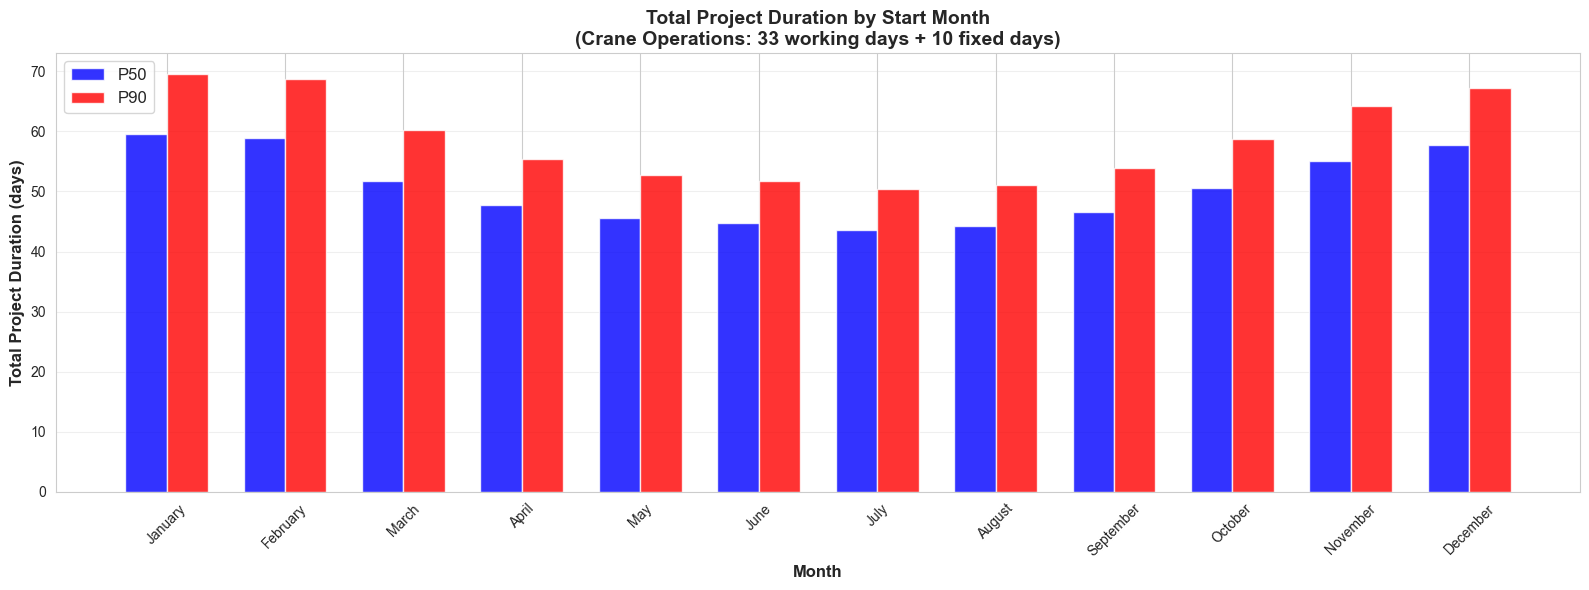


✓ Month comparison complete


In [8]:
# Cell 8: Compare Different Start Months

print("\n[PART 7] Month-by-Month Comparison...\n")

# Calculate for all 12 months
monthly_comparison = []

for month in range(1, 13):
    month_name = pd.to_datetime(f'2020-{month:02d}-01').strftime('%B')
    
    # Get historical data for this month
    df_month = df[df['month'] == month]
    
    if len(df_month) > 0:
        workability = df_month['workable'].mean()
        
        # Calculate durations
        p50_days = calculate_project_duration(weather_dependent_days, workability, 'P50')
        p90_days = calculate_project_duration(weather_dependent_days, workability, 'P90')
        
        total_p50 = fixed_days + p50_days
        total_p90 = fixed_days + p90_days
        
        monthly_comparison.append({
            'Month': month_name,
            'Workability': workability,
            'Weather_Days_P50': p50_days,
            'Weather_Days_P90': p90_days,
            'Total_P50': total_p50,
            'Total_P90': total_p90,
            'Weather_Delay_P50': p50_days - weather_dependent_days,
            'Weather_Delay_P90': p90_days - weather_dependent_days
        })

df_monthly_comp = pd.DataFrame(monthly_comparison)

print("="*80)
print("MONTH-BY-MONTH COMPARISON (Total Project Duration)")
print("="*80)
print(df_monthly_comp[['Month', 'Workability', 'Total_P50', 'Total_P90', 'Weather_Delay_P90']].to_string(
    index=False,
    float_format=lambda x: f"{x:.1f}" if x > 1 else f"{x:.1%}"
))

# Best and worst months
best_month = df_monthly_comp.loc[df_monthly_comp['Total_P90'].idxmin()]
worst_month = df_monthly_comp.loc[df_monthly_comp['Total_P90'].idxmax()]

print("\n" + "="*80)
print("BEST & WORST MONTHS:")
print("="*80)
print(f"✅ BEST: {best_month['Month']} - {best_month['Total_P90']:.0f} days (P90)")
print(f"❌ WORST: {worst_month['Month']} - {worst_month['Total_P90']:.0f} days (P90)")
print(f"\n📊 Difference: {worst_month['Total_P90'] - best_month['Total_P90']:.0f} days")
print(f"   → Scheduling in {best_month['Month']} saves {(worst_month['Total_P90'] - best_month['Total_P90']):.0f} days vs {worst_month['Month']}!")
print("="*80)

# Visualization
fig, ax = plt.subplots(figsize=(16, 6))

x = np.arange(len(df_monthly_comp))
width = 0.35

ax.bar(x - width/2, df_monthly_comp['Total_P50'], width, label='P50', alpha=0.8, color='blue')
ax.bar(x + width/2, df_monthly_comp['Total_P90'], width, label='P90', alpha=0.8, color='red')

ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Project Duration (days)', fontweight='bold', fontsize=12)
ax.set_title(f'Total Project Duration by Start Month\n({op_type} Operations: {weather_dependent_days} working days + {fixed_days} fixed days)', 
             fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_monthly_comp['Month'], rotation=45)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Month comparison complete")

## PART 8: SUMMARY & RECOMMENDATIONS

In [9]:
# Cell 9: Final Summary

print("\n" + "="*80)
print("PHASE 6 COMPLETE: PROJECT DURATION ESTIMATION")
print("="*80)

print("\n📋 YOUR PROJECT:")
print("-"*80)
print(f"Operation: {op_type}")
print(f"Start Date: {PROJECT_CONFIG['start_date']} ({start_month})")
print(f"Working Days Required: {weather_dependent_days} days (Calib: {PROJECT_CONFIG['calibration_days']}, Op: {PROJECT_CONFIG['operation_days']})")
print(f"Fixed Days: {fixed_days} days (Mob/Transit/Demob)")

print("\n📊 ESTIMATED DURATION ({}):".format(confidence))
print("-"*80)
print(f"Total Project Duration: {total_duration:.0f} calendar days")
print(f"Weather Delay: {weather_delay:.1f} days")
print(f"End Date: {end_date.strftime('%d-%B-%Y')}")

if PROJECT_CONFIG['include_contingency']:
    print(f"\nWith 10% Contingency: {total_with_contingency:.0f} days")
    print(f"End Date (Contingency): {end_with_contingency.strftime('%d-%B-%Y')}")

print("\n💡 RECOMMENDATIONS:")
print("-"*80)

# Compare to best/worst
current_month_data = df_monthly_comp[df_monthly_comp['Month'] == start_month].iloc[0]
rank = (df_monthly_comp['Total_P90'] <= current_month_data['Total_P90']).sum()

print(f"1. YOUR SELECTED MONTH: {start_month}")
print(f"   Rank: {rank}/12 (1=best, 12=worst)")

if rank <= 3:
    print(f"   ✅ EXCELLENT choice! {start_month} is one of the best months.")
elif rank <= 6:
    print(f"   ⚠️  MODERATE choice. Consider {best_month['Month']} for shorter duration.")
else:
    print(f"   ❌ POOR choice. Strongly recommend {best_month['Month']} instead.")
    print(f"   → Potential savings: {current_month_data['Total_P90'] - best_month['Total_P90']:.0f} days")

print(f"\n2. BEST ALTERNATIVE: {best_month['Month']}")
print(f"   Total Duration (P90): {best_month['Total_P90']:.0f} days")
print(f"   Workability: {best_month['Workability']:.1%}")

print(f"\n3. AVOID: {worst_month['Month']}")
print(f"   Total Duration (P90): {worst_month['Total_P90']:.0f} days")
print(f"   Adds {worst_month['Total_P90'] - best_month['Total_P90']:.0f} extra days vs best month!")

print("\n" + "="*80)
print("⚠️  METHODOLOGY VALIDATION (PHASE 1-5):")
print("="*80)
print("This estimate is based on:")
print("  ✅ Phase 1-2: 10 years historical data (2015-2025)")
print("  ✅ Validated workability thresholds")
print("  ✅ Statistical weather window analysis")
print("\n📍 Location: UK Northeast Coast ONLY")
print("   Different locations require re-analysis!")
print("="*80)

print("\n🎯 READY FOR TENDER ESTIMATION!")
print("="*80)


PHASE 6 COMPLETE: PROJECT DURATION ESTIMATION

📋 YOUR PROJECT:
--------------------------------------------------------------------------------
Operation: Crane
Start Date: 15-June-2026 (June)
Working Days Required: 33 days (Calib: 3, Op: 30)
Fixed Days: 10 days (Mob/Transit/Demob)

📊 ESTIMATED DURATION (P90):
--------------------------------------------------------------------------------
Total Project Duration: 51 calendar days
Weather Delay: 7.7 days
End Date: 04-August-2026

With 10% Contingency: 56 days
End Date (Contingency): 09-August-2026

💡 RECOMMENDATIONS:
--------------------------------------------------------------------------------
1. YOUR SELECTED MONTH: June
   Rank: 3/12 (1=best, 12=worst)
   ✅ EXCELLENT choice! June is one of the best months.

2. BEST ALTERNATIVE: July
   Total Duration (P90): 50 days
   Workability: 98.0%

3. AVOID: January
   Total Duration (P90): 70 days
   Adds 19 extra days vs best month!

⚠️  METHODOLOGY VALIDATION (PHASE 1-5):
This estimate is